In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import gc 

In [2]:
print('Loading data ...')

train = pd.read_csv("train_2016.csv", parse_dates=["transactiondate"])
prop = pd.read_csv("properties_2016.csv") 

# Use the columns that are floats
for c, dtype in zip(prop.columns, prop.dtypes):	
    if dtype == np.float64:		
        prop[c] = prop[c].astype(np.float32)
        
# Create the train and validation sets 
df_train = train.merge(prop, how='left', on='parcelid')
drop_cols1 = ['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode']
x_train = df_train.drop(drop_cols1, axis=1)
y_train = df_train['logerror'].values
print(x_train.shape, y_train.shape)


Loading data ...


C:\Users\board\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(90811, 55) (90811,)


In [3]:
train.shape

(90811, 3)

In [4]:
train_columns = x_train.columns
# Not sure what loop below does 
for c in x_train.dtypes[x_train.dtypes == object].index.values:
    x_train[c] = (x_train[c] == True)

# Garbage clean up - delete variables we don't need 
#del df_train; gc.collect()

# Create train and validation set 
split = 90000
x_train, y_train, x_valid, y_valid = x_train[:split], y_train[:split], x_train[split:], y_train[split:]
x_train = x_train.values.astype(np.float32, copy=False)
x_valid = x_valid.values.astype(np.float32, copy=False)

# Prepare data for lgbm method 
d_train = lgb.Dataset(x_train, label=y_train)
d_valid = lgb.Dataset(x_valid, label=y_valid)


### Light GBM preparation 

In [5]:
# Hyper parameters of GBM model 
params = {}
params['learning_rate'] = 0.002
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mae'
params['sub_feature'] = 0.5
params['num_leaves'] = 50
params['min_data'] = 400
params['min_hessian'] = 1


#del d_train, d_valid; gc.collect()
#del x_train, x_valid; gc.collect()

[1]	valid_0's l1: 0.0723926
[2]	valid_0's l1: 0.072389
[3]	valid_0's l1: 0.0723882
[4]	valid_0's l1: 0.0723865
[5]	valid_0's l1: 0.072386
[6]	valid_0's l1: 0.072381
[7]	valid_0's l1: 0.0723768
[8]	valid_0's l1: 0.0723758
[9]	valid_0's l1: 0.0723734
[10]	valid_0's l1: 0.0723721
[11]	valid_0's l1: 0.0723682
[12]	valid_0's l1: 0.0723673
[13]	valid_0's l1: 0.0723654
[14]	valid_0's l1: 0.0723637
[15]	valid_0's l1: 0.0723616
[16]	valid_0's l1: 0.0723593
[17]	valid_0's l1: 0.0723579
[18]	valid_0's l1: 0.0723557
[19]	valid_0's l1: 0.0723541
[20]	valid_0's l1: 0.0723529
[21]	valid_0's l1: 0.072347
[22]	valid_0's l1: 0.0723435
[23]	valid_0's l1: 0.0723447
[24]	valid_0's l1: 0.0723426
[25]	valid_0's l1: 0.0723369
[26]	valid_0's l1: 0.0723355
[27]	valid_0's l1: 0.0723307
[28]	valid_0's l1: 0.0723284
[29]	valid_0's l1: 0.0723244
[30]	valid_0's l1: 0.0723219
[31]	valid_0's l1: 0.0723201
[32]	valid_0's l1: 0.0723184
[33]	valid_0's l1: 0.0723165
[34]	valid_0's l1: 0.0723129
[35]	valid_0's l1: 0.072311

In [ ]:
# Fit the model 
watchlist = [d_valid]
clf = lgb.train(params, d_train, 500, watchlist)

In [ ]:
clf.eval_train

### Start Feature Importance Analysis  

Feature importance can help us understand the important variables for the model 

In [13]:
feature_importance1 = pd.DataFrame(data = clf.feature_importance().T, index = train_columns, columns={"LGBM number"})
feature_importance1.head()

,LGBM number
airconditioningtypeid,56
architecturalstyletypeid,0
basementsqft,0
bathroomcnt,346
bedroomcnt,586


In [21]:
# See which features have 0 importance 
print(len(feature_importance1[feature_importance1["LGBM number"] == 0]))
feature_importance1[feature_importance1["LGBM number"]  == 0]

13


,LGBM number
architecturalstyletypeid,0
basementsqft,0
buildingclasstypeid,0
decktypeid,0
finishedsquarefeet13,0
finishedsquarefeet6,0
pooltypeid10,0
storytypeid,0
typeconstructiontypeid,0
yardbuildingsqft26,0


In [23]:
feature_importance1[feature_importance1["LGBM number"] != 0]

,LGBM number
airconditioningtypeid,56
bathroomcnt,346
bedroomcnt,586
buildingqualitytypeid,344
calculatedbathnbr,313
finishedfloor1squarefeet,95
calculatedfinishedsquarefeet,2002
finishedsquarefeet12,2459
finishedsquarefeet15,262
finishedsquarefeet50,78


We have a large variance of feature importances. The higher the better but we may want to get rid of the low importance variables for stability.  
More variables could lead to better performance at the cost of more variance in the outcome. In this case we may not want as much variance in our outcome because the test set is so much larger than the training set.  

First let's calculate the feature importance ratio for each of the variables. 

In [24]:
feat_imp_sum = feature_importance1["LGBM number"].sum()
feature_importance1["feature importance ratio"] = feature_importance1["LGBM number"].div(feat_imp_sum,axis = 0)
feature_importance1.head()

,LGBM number,feature importance ratio
airconditioningtypeid,56,0.001898
architecturalstyletypeid,0,0.000000
basementsqft,0,0.000000
bathroomcnt,346,0.011729
bedroomcnt,586,0.019864


In [25]:
feature_importance1.sort_values(["feature importance ratio"], ascending=False)

,LGBM number,feature importance ratio
finishedsquarefeet12,2459,0.083356
calculatedfinishedsquarefeet,2002,0.067864
lotsizesquarefeet,1987,0.067356
regionidzip,1982,0.067186
structuretaxvaluedollarcnt,1965,0.066610
yearbuilt,1939,0.065729
taxvaluedollarcnt,1746,0.059186
latitude,1571,0.053254
longitude,1531,0.051898
taxamount,1523,0.051627


Interesting that the variable with the most importance about 8% of the total.  
There are a lot of values with very low feature importance as well.  
Let's arbitrarily take out the variables with less than 1% of the feature importance 

In [26]:
# Number of features with relative ratio greater than 1% 
len(feature_importance1[feature_importance1["feature importance ratio"] > 0.01])

23

In [27]:
feature_importance1[feature_importance1["feature importance ratio"] > 0.01]

,LGBM number,feature importance ratio
bathroomcnt,346,0.011729
bedroomcnt,586,0.019864
buildingqualitytypeid,344,0.011661
calculatedbathnbr,313,0.010610
calculatedfinishedsquarefeet,2002,0.067864
finishedsquarefeet12,2459,0.083356
garagetotalsqft,472,0.016000
heatingorsystemtypeid,420,0.014237
latitude,1571,0.053254
longitude,1531,0.051898


In [39]:
low_feat_imp_variables = feature_importance1[feature_importance1["feature importance ratio"] < 0.01].index
# add low feature importance variables to the identifiers (and other variables we don't want in ) 
drop_cols2 = low_feat_imp_variables.append(pd.Index(drop_cols1))

In [42]:
# Make a new training dataset (from original imported dataset )
x_train1 = df_train.drop(drop_cols2, axis = 1)
x_train1.shape

(90811, 23)

In [45]:
train_columns = x_train1.columns

# Not sure what this loop does 
for c in x_train1.dtypes[x_train1.dtypes == object].index.values:
    x_train1[c] = (x_train1[c] == True)

#del df_train; gc.collect()

#Recreate the training and test datasets with only the new columns we want 
split = 90000
x_train2, y_train2, x_valid2, y_valid2 = x_train1[:split], y_train[:split], x_train1[split:], y_train[split:]
x_train2 = x_train2.values.astype(np.float32, copy=False)
x_valid2 = x_valid2.values.astype(np.float32, copy=False)

d_train2 = lgb.Dataset(x_train2, label=y_train2)
d_valid2 = lgb.Dataset(x_valid2, label=y_valid2)

In [55]:
# Train new model with fewer variables 
watchlist = [d_valid2]
clf1 = lgb.train(params, d_train2, 500, watchlist)

[1]	valid_0's l1: 0.0107558
[2]	valid_0's l1: 0.0107607
[3]	valid_0's l1: 0.0107618
[4]	valid_0's l1: 0.0107627
[5]	valid_0's l1: 0.0107633
[6]	valid_0's l1: 0.0107635
[7]	valid_0's l1: 0.010765
[8]	valid_0's l1: 0.0107692
[9]	valid_0's l1: 0.0107711
[10]	valid_0's l1: 0.0107718
[11]	valid_0's l1: 0.0107738
[12]	valid_0's l1: 0.0107753
[13]	valid_0's l1: 0.0107785
[14]	valid_0's l1: 0.0107805
[15]	valid_0's l1: 0.0107821
[16]	valid_0's l1: 0.0107835
[17]	valid_0's l1: 0.0107871
[18]	valid_0's l1: 0.0107882
[19]	valid_0's l1: 0.0107871
[20]	valid_0's l1: 0.0107906
[21]	valid_0's l1: 0.0107913
[22]	valid_0's l1: 0.0107927
[23]	valid_0's l1: 0.0107938
[24]	valid_0's l1: 0.0107958
[25]	valid_0's l1: 0.0107994
[26]	valid_0's l1: 0.0108038
[27]	valid_0's l1: 0.0108073
[28]	valid_0's l1: 0.0108109
[29]	valid_0's l1: 0.0108114
[30]	valid_0's l1: 0.0108156
[31]	valid_0's l1: 0.0108174
[32]	valid_0's l1: 0.0108172
[33]	valid_0's l1: 0.0108194
[34]	valid_0's l1: 0.0108236
[35]	valid_0's l1: 0.010

In [56]:
clf1.eval_train()

[('training', 'l1', 0.068417250488747902, False)]

### Let's do some analysis on the model errors 

In [177]:
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns

In [178]:
# Look at the distributions for the output and our predictions 
scores = pd.Series(clf1.predict(x_train))
print("Score Quantiles: \n", scores.quantile(q = [0.25, 0.5, 0.75]))
print("Actual Quantiles: \n", pd.Series(y_train).quantile(q = [0.25, 0.5, 0.75]))

Score Quantiles: 
 0.25   -0.018101
0.50   -0.017973
0.75   -0.005734
dtype: float64
Actual Quantiles: 
 0.25   -0.0263
0.50    0.0050
0.75    0.0383
dtype: float64


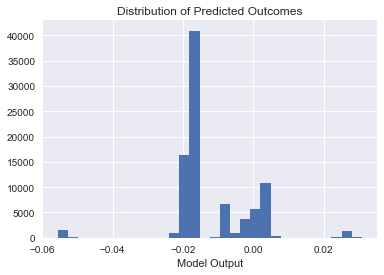

In [179]:
plt.hist(scores, bins=30)
plt.title("Distribution of Predicted Outcomes")
plt.xlabel("Model Output")
plt.ylabel("Number of occurances")

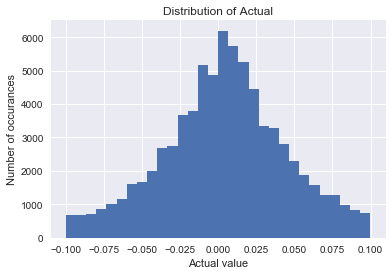

In [180]:
plt.hist(y_train[abs(y_train) < 0.1], bins = 30)
plt.title("Distribution of Actual")
plt.xlabel("Actual value")
plt.ylabel("Number of occurances")

Looks like something is going wrong. It could be beacuse we used the default hyper parameters from the previous notebook.  
We should try another model with better hyper paramters. 

### Light GBM Cross Validation  

Let's use a grid search and cross validation to find the best set of hyper paramters for the model.  

In [80]:
# Set parameters that will be the same for all the cross validated models 

params2 = {}
#params2['learning_rate'] = 0.002
params2['boosting_type'] = 'gbdt'
params2['objective'] = 'regression'
params2['metric'] = 'mae'
params2['sub_feature'] = 0.5
#params2['num_leaves'] = 50
#params2['min_data'] = 400
params2['min_hessian'] = 1

In [97]:
# Use the lgbm sci kit learn wrapper (so we can use grid search cv)
estimator = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', metric = 'mae')

In [135]:
# initial grid for hyper parameters 
param_grid2 = {
    'learning_rate': [0.001, 0.01, 0.1], 
    'n_estimators': [20, 30, 50, 100], 
    'num_leaves': [10, 30, 60],
    'min_data': [300, 500, 700]
}
# Signing up for 3*4*3*3 models  = 108 models 

In [123]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [129]:
# Prepare for cross validation 
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
gbm_grid = GridSearchCV(estimator, param_grid2, cv = kfold)

In [130]:
# Fit the gbm model 
gbm_grid.fit(x_train2, y_train2)
#gbm_grid.cv_results_

C:\Users\board\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=9.
  % (min_groups, self.n_splits)), Warning)


GridSearchCV(cv=StratifiedKFold(n_splits=9, random_state=1234, shuffle=True),
       error_score='raise',
       estimator=LGBMRegressor(boosting_type='gbdt', colsample_bytree=1, learning_rate=0.1,
       max_bin=255, max_depth=-1, metric='mae', min_child_samples=10,
       min_child_weight=5, min_split_gain=0, n_estimators=10, nthread=-1,
       num_leaves=31, objective='regression', reg_alpha=0, reg_lambda=0,
       seed=0, silent=True, subsample=1, subsample_for_bin=50000,
       subsample_freq=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_data': [300, 500, 700], 'n_estimators': [20, 30, 50, 100], 'num_leaves': [10, 30, 60], 'learning_rate': [0.0001, 0.001, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [131]:
gbm_grid.best_params_

{'learning_rate': 0.1, 'min_data': 300, 'n_estimators': 100, 'num_leaves': 30}

In [132]:
gbm_grid.best_score_

0.020111474894589251

(array([ 75.,  17.,   9.,   8.,   5.,   6.,   6.,   5.,   2.,   1.,   2.,
          2.,   1.,   2.,   0.,   1.,   0.,   1.,   0.,   1.]),
 array([  4.37836835e-05,   5.16879093e-03,   1.02937982e-02,
          1.54188054e-02,   2.05438127e-02,   2.56688199e-02,
          3.07938272e-02,   3.59188344e-02,   4.10438417e-02,
          4.61688489e-02,   5.12938562e-02,   5.64188634e-02,
          6.15438707e-02,   6.66688779e-02,   7.17938852e-02,
          7.69188924e-02,   8.20438997e-02,   8.71689069e-02,
          9.22939142e-02,   9.74189214e-02,   1.02543929e-01]),
 <a list of 20 Patch objects>)

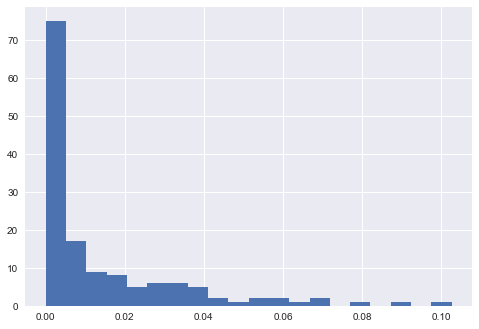

In [133]:
plt.hist(gbm_grid.cv_results_["mean_train_score"], bins = 20) 

In [ ]:
# Finer grid based on previous values 
param_grid3 = {
    'learning_rate': [0.05, 0.1, 0.15], 
    'n_estimators': [125, 175, 250], 
    'num_leaves': [13,15, 20], 
    'min_data': [150, 225, 300]
}

In [136]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
gbm_grid3 = GridSearchCV(estimator, param_grid3, cv = kfold)
gbm_grid3.fit(x_train2, y_train2)
#gbm_grid.cv_results_

C:\Users\board\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=9.
  % (min_groups, self.n_splits)), Warning)


GridSearchCV(cv=StratifiedKFold(n_splits=9, random_state=1234, shuffle=True),
       error_score='raise',
       estimator=LGBMRegressor(boosting_type='gbdt', colsample_bytree=1, learning_rate=0.1,
       max_bin=255, max_depth=-1, metric='mae', min_child_samples=10,
       min_child_weight=5, min_split_gain=0, n_estimators=10, nthread=-1,
       num_leaves=31, objective='regression', reg_alpha=0, reg_lambda=0,
       seed=0, silent=True, subsample=1, subsample_for_bin=50000,
       subsample_freq=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_data': [150, 225, 300, 375, 425], 'n_estimators': [75, 100, 125, 175, 250], 'num_leaves': [4, 7, 10, 15], 'learning_rate': [0.05, 0.1, 0.15, 0.2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [168]:
gbm_grid3.cv_results_.keys() 

dict_keys(['std_train_score', 'split2_train_score', 'params', 'split7_test_score', 'split3_train_score', 'mean_test_score', 'param_min_data', 'split8_test_score', 'param_learning_rate', 'std_test_score', 'split4_train_score', 'mean_score_time', 'split2_test_score', 'param_n_estimators', 'split5_train_score', 'mean_train_score', 'split0_test_score', 'split8_train_score', 'split1_train_score', 'split0_train_score', 'split4_test_score', 'split6_train_score', 'split7_train_score', 'param_num_leaves', 'std_fit_time', 'split5_test_score', 'mean_fit_time', 'rank_test_score', 'split1_test_score', 'std_score_time', 'split3_test_score', 'split6_test_score'])

In [141]:
print("Refined Grid Best Details")
print(gbm_grid3.best_params_)
print(gbm_grid3.best_score_) 

Refined Grid Best Details
{'n_estimators': 175, 'min_data': 225, 'num_leaves': 15, 'learning_rate': 0.1}
0.0201073083654


In [142]:
print("First Grid Best Details")
print(gbm_grid.best_params_)
print(gbm_grid.best_score_) 

First Grid Best Details
{'n_estimators': 100, 'min_data': 300, 'num_leaves': 30, 'learning_rate': 0.1}
0.0201114748946


In [171]:
min(gbm_grid3.cv_results_['mean_train_score'])

0.01319132997634229

In [175]:
#print("Mean: ", gbm_grid3.cv_results_['mean_train_score'])
#print("Std: ", gbm_grid3.cv_results_['std_train_score'])
len(gbm_grid3.cv_results_['mean_train_score'])

400

In [170]:
gbm_grid3.cv_results_.keys()

dict_keys(['std_train_score', 'split2_train_score', 'params', 'split7_test_score', 'split3_train_score', 'mean_test_score', 'param_min_data', 'split8_test_score', 'param_learning_rate', 'std_test_score', 'split4_train_score', 'mean_score_time', 'split2_test_score', 'param_n_estimators', 'split5_train_score', 'mean_train_score', 'split0_test_score', 'split8_train_score', 'split1_train_score', 'split0_train_score', 'split4_test_score', 'split6_train_score', 'split7_train_score', 'param_num_leaves', 'std_fit_time', 'split5_test_score', 'mean_fit_time', 'rank_test_score', 'split1_test_score', 'std_score_time', 'split3_test_score', 'split6_test_score'])

In [176]:
min(gbm_grid3.cv_results_['mean_train_score'])

0.01319132997634229